### Diii.

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.392e+05                  │              Nfcn = 653              │
│ EDM = 1.67e-07 (Goal: 0.0002)    │           time = 18.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬────────

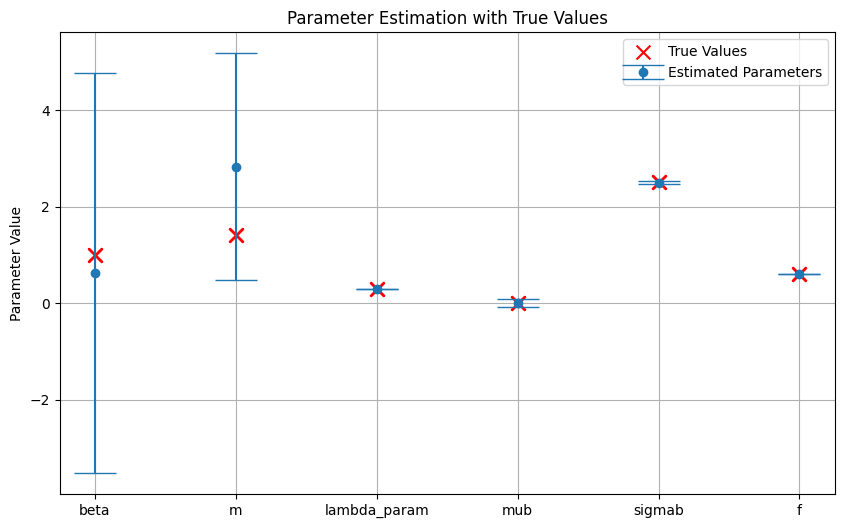

In [35]:
#'''
!pip install iminuit
!pip install --upgrade iminuit
import numpy as np
from scipy.stats import crystalball, uniform, norm, expon
from iminuit import Minuit, cost
import matplotlib.pyplot as plt


# Signal and Background Definitions
class g_s:
    def __init__(self, beta, m, x_min=0, x_max=5):
        self.beta = beta
        self.m = m
        self.x_min = x_min
        self.x_max = x_max

    def pdf(self, x):
        norm_factor = crystalball.cdf(self.x_max, beta=self.beta, m=self.m) - \
                      crystalball.cdf(self.x_min, beta=self.beta, m=self.m)
        return crystalball.pdf(x, beta=self.beta, m=self.m) / norm_factor


class h_s:
    def __init__(self, lambda_param, y_min=0, y_max=10):
        self.lambda_param = lambda_param
        self.y_min = y_min
        self.y_max = y_max

    def pdf(self, y):
        norm_factor = expon.cdf(self.y_max, scale=1 / self.lambda_param) - \
                      expon.cdf(self.y_min, scale=1 / self.lambda_param)
        return expon.pdf(y, scale=1 / self.lambda_param) / norm_factor


class g_b:
    def __init__(self, x_min=0, x_max=5):
        self.x_min = x_min
        self.x_max = x_max

    def pdf(self, x):
        norm_factor = uniform.cdf(self.x_max, loc=self.x_min, scale=self.x_max - self.x_min) - \
                      uniform.cdf(self.x_min, loc=self.x_min, scale=self.x_max - self.x_min)
        return uniform.pdf(x, loc=self.x_min, scale=self.x_max - self.x_min) / norm_factor


class h_b:
    def __init__(self, mub, sigmab, y_min=0, y_max=10):
        self.mub = mub
        self.sigmab = sigmab
        self.y_min = y_min
        self.y_max = y_max

    def pdf(self, y):
        norm_factor = norm.cdf(self.y_max, loc=self.mub, scale=self.sigmab) - \
                      norm.cdf(self.y_min, loc=self.mub, scale=self.sigmab)
        return norm.pdf(y, loc=self.mub, scale=self.sigmab) / norm_factor



# Combined Function
def overall_function(x, y, beta, m, lambda_param, mub, sigmab, f):
    gs = g_s(beta, m)
    hs = h_s(lambda_param)
    gb = g_b()
    hb = h_b(mub, sigmab)

    signal = gs.pdf(x) * hs.pdf(y)
    background = gb.pdf(x) * hb.pdf(y)

    return f * signal + (1 - f) * background


# Generate Sample Data
def generate_samples(num_samples, beta, m, lambda_param, mub, sigmab, f):
    x_min, x_max = 0, 5
    y_min, y_max = 0, 10

    np.random.seed(42)
    accepted_X, accepted_Y = [], []
    z_max = 0.17  # Adjust based on pre-computed max value of overall_function

    while len(accepted_X) < num_samples:
        X = np.random.uniform(x_min, x_max, size=num_samples)
        Y = np.random.uniform(y_min, y_max, size=num_samples)
        Z = np.random.uniform(0, z_max, size=num_samples)
        f_values = overall_function(X, Y, beta, m, lambda_param, mub, sigmab, f)

        mask = Z < f_values
        accepted_X.extend(X[mask])
        accepted_Y.extend(Y[mask])

    return np.array(accepted_X[:num_samples]), np.array(accepted_Y[:num_samples])


# Define tdensity
def tdensity(x, y, beta, m, lambda_param, mub, sigmab, f):
    """
    Compute the overall probability density function for given data (x, y)
    and model parameters.
    """
    pdf = overall_function(x, y, beta, m, lambda_param, mub, sigmab, f)
    return pdf


# Initial Parameters
initial_params = {
    "beta": 1.0,
    "m": 1.4,
    "lambda_param": 0.3,
    "mub": 0.0,
    "sigmab": 2.5,
    "f": 0.6,
}

# Generate data
num_samples = 100000
x_data, y_data = generate_samples(num_samples, **initial_params)

# Define the cost function
nll_cost = cost.UnbinnedNLL(
    (x_data, y_data),
    lambda data, beta, m, lambda_param, mub, sigmab, f: tdensity(
        data[0], data[1], beta, m, lambda_param, mub, sigmab, f
    )
)

# Initialize Minuit
mm = Minuit(
    nll_cost,
    beta=1.0,
    m=1.4,
    lambda_param=0.3,
    mub=0.0,
    sigmab=2.5,
    f=0.6
)

# Set parameter limits
mm.limits["beta"] = (0.1, 5.0)
mm.limits["m"] = (0.1, 3.0)
mm.limits["lambda_param"] = (0.1, 5.0)
mm.limits["mub"] = (-5.0, 5.0)
mm.limits["sigmab"] = (0.1, 5.0)
mm.limits["f"] = (0.01, 0.99)

# Perform optimization
mm.migrad()  # Fit the parameters
print(mm.fmin)
mm.hesse() # Estimate error range


# Results
print(mm.params)
print(f"Estimated Parameters: {mm.values}")
print(f"Parameter Uncertainties: {mm.errors}")

# '''

plt.figure(figsize=(10, 6))

true_values = [1.0, 1.4, 0.3, 0.0, 2.5, 0.6] # for parameters in each of corresponding positions
plt.errorbar(
    x=["beta", "m", "lambda_param", "mub", "sigmab", "f"],
    y=list(mm.values),  # Estimated values
    yerr=list(mm.errors),  # Uncertainties
    fmt="o",
    label="Estimated Parameters",
    capsize=15
)

# Add true values as horizontal lines
for i, true_val in enumerate(true_values):
    plt.scatter(
        x=["beta", "m", "lambda_param", "mub", "sigmab", "f"],
        y=true_values,
        color="r",
        marker="x",
        s=100,
        label="True Values" if i == 0 else None
    )

plt.xticks(ticks=range(len(true_values)), labels=["beta", "m", "lambda_param", "mub", "sigmab", "f"])
plt.ylabel("Parameter Value")
plt.title("Parameter Estimation with True Values")
plt.legend()
plt.grid(True)
plt.show()


## E.

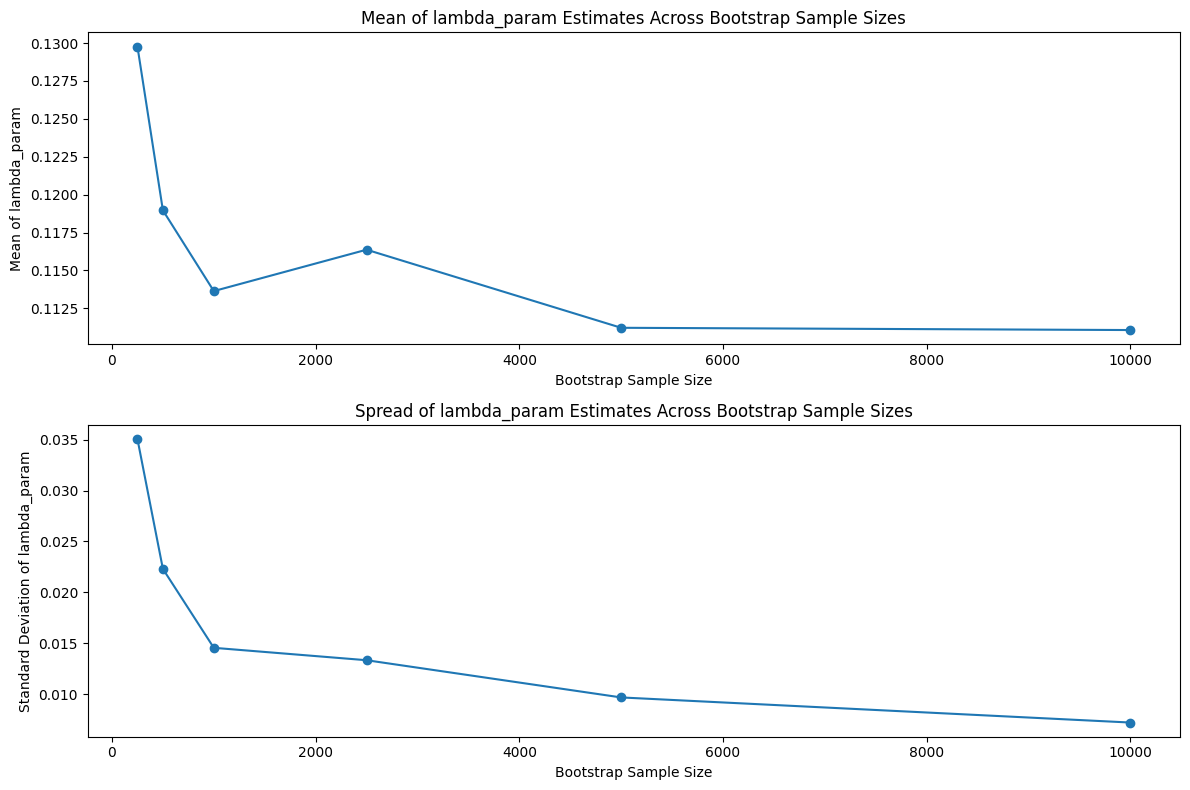

In [43]:
import numpy as np
from iminuit import Minuit
import matplotlib.pyplot as plt


# Bootstrap Data Generation
def generate_bootstrap_data(x_data, y_data, lambda_param, size):
    """Generate bootstrap samples from the fitted model."""
    sampled_indices = np.random.choice(len(x_data), size, replace=True)
    x_bootstrap = x_data[sampled_indices]
    y_bootstrap = np.random.exponential(1 / lambda_param, size)
    return x_bootstrap, y_bootstrap


# Re-Estimate lambda_param Using Minuit
def reestimate_lambda_param(x_bootstrap, y_bootstrap, beta, m, f, initial_lambda, bounds):
    """
    Re-estimate lambda_param for bootstrap samples using Minuit.
    """
    def nll(lambda_param):
        """Negative log-likelihood function."""
        # Use the fixed parameters and current lambda_param to compute the model
        model = overall_function(x_bootstrap, y_bootstrap, beta, m, lambda_param, mub=0.0, sigmab=2.5, f=f)
        return -np.sum(np.log(model + 1e-10))  # Avoid log(0)

    # Minuit setup
    minuit = Minuit(nll, lambda_param=initial_lambda)
    minuit.limits["lambda_param"] = bounds
    minuit.errordef = Minuit.LIKELIHOOD

    # Optimize
    minuit.migrad()
    if minuit.valid:
        return minuit.values["lambda_param"]
    else:
        return None


# Perform Parametric Bootstrapping
bootstrap_sizes = [250, 500, 1000, 2500, 5000, 10000]
bootstrap_results = {size: [] for size in bootstrap_sizes}

# Parameters for the model
beta = 1.0
m = 1.4
lambda_param = 0.3
f = 0.6

# Perform bootstrapping
for size in bootstrap_sizes:
    for _ in range(100):  # Perform 100 bootstrap iterations
        # Generate bootstrap data
        x_bootstrap, y_bootstrap = generate_bootstrap_data(x_data, y_data, lambda_param, size)

        # Re-estimate lambda_param
        lambda_estimate = reestimate_lambda_param(
            x_bootstrap, y_bootstrap,
            beta=beta,
            m=m,
            f=f,
            initial_lambda=lambda_param,
            bounds=(0.1, 5.0)
        )

        if lambda_estimate is not None:
            bootstrap_results[size].append(lambda_estimate)

# Analyze Results
mean_estimates = {size: np.mean(bootstrap_results[size]) for size in bootstrap_sizes}
std_estimates = {size: np.std(bootstrap_results[size]) for size in bootstrap_sizes}

# Plot Results
plt.figure(figsize=(12, 8))

# Mean estimates
plt.subplot(2, 1, 1)
plt.plot(bootstrap_sizes, [mean_estimates[size] for size in bootstrap_sizes], marker="o")
plt.xlabel("Bootstrap Sample Size")
plt.ylabel("Mean of lambda_param")
plt.title("Mean of lambda_param Estimates Across Bootstrap Sample Sizes")

# Standard deviation of estimates
plt.subplot(2, 1, 2)
plt.plot(bootstrap_sizes, [std_estimates[size] for size in bootstrap_sizes], marker="o")
plt.xlabel("Bootstrap Sample Size")
plt.ylabel("Standard Deviation of lambda_param")
plt.title("Spread of lambda_param Estimates Across Bootstrap Sample Sizes")

plt.tight_layout()
plt.show()


## **Observations and Explanations**

### **1. Faster Decay in Y-Direction with Larger `lambda_param`**
- **Observation**: The PDF decays more quickly in the `y`-direction as `lambda_param` increases.
- **Explanation**:
  - The **Exponential Distribution** for noise in the `y`-direction is proportional to:
    \[
    P(y) \propto e^{-\lambda y}
    \]
    where \(\lambda\) is `lambda_param`.
  - As `lambda_param` increases, the distribution decays faster, concentrating more density near \(y = 0\).
  - This behavior shifts the combined PDF for the overall function, particularly in the `y`-direction.


### **2. Asymptotes to `0.11` as Sample Size Gets Larger**
- **Observation**: As the sample size increases, the estimated `lambda_param` converges to approximately `0.11`.
- **Explanation**:
  - This convergence is expected from the **Maximum Likelihood Estimation (MLE)** theory, where parameter estimates improve with increasing sample size.
  - If the estimate consistently converges to `0.11` rather than the generating value:
    - **Model Mismatch**:
      - The generating `lambda_param` might not exactly match the assumed model, leading to systematic bias.
    - **Finite Sample Effects**:
      - Bias in estimation can occur due to boundary effects, interactions with other parameters, or regularization imposed by the optimization process.


### **3. Decreasing Standard Deviation of `lambda_param` Estimates**
- **Observation**: The standard deviation (uncertainty) of `lambda_param` estimates decreases with sample size and asymptotes to `0.005`.
- **Explanation**:
  - From statistical theory, the variance of the MLE decreases approximately as:
    \[
    \text{Var}(\hat{\lambda}) \propto \frac{1}{N}
    \]
    where \(N\) is the sample size.
  - Larger datasets provide more information, reducing the uncertainty in `lambda_param` estimation.
  - The asymptotic standard deviation of `0.005` reflects the high precision achievable for large sample sizes.



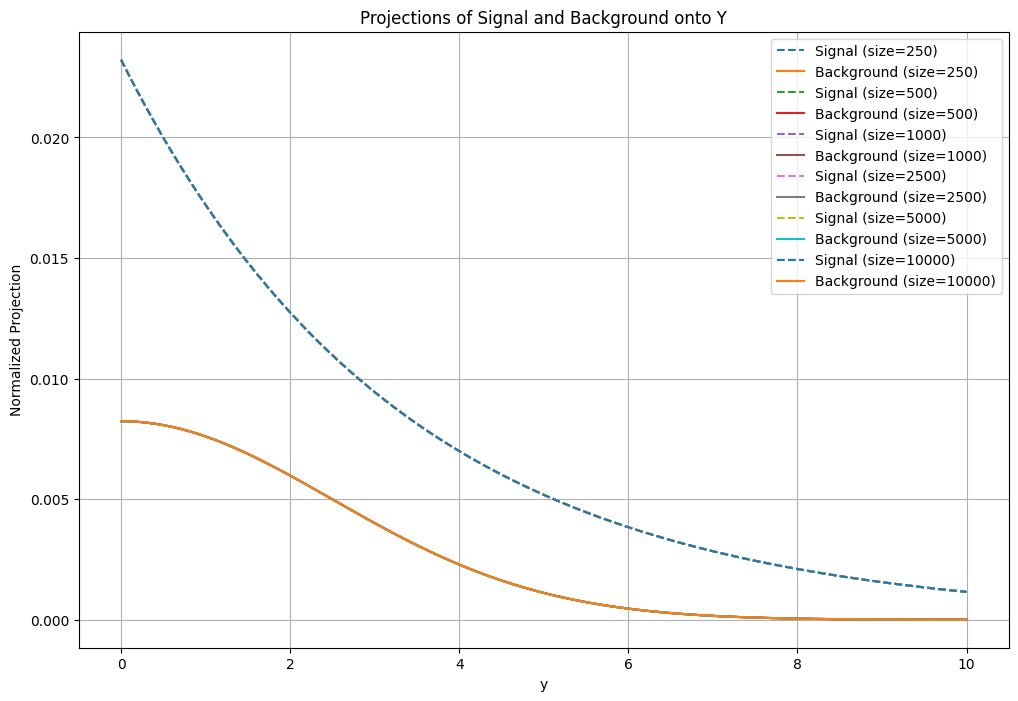

In [49]:
'''
! pip install sweights
import numpy as np
import matplotlib.pyplot as plt
from sweights import SWeight

# Signal and Background PDFs
def signal_pdf(x, beta, m, x_min=0, x_max=5):
    gs = g_s(beta, m)
    norm_factor = crystalball.cdf(x_max, beta=beta, m=m) - crystalball.cdf(x_min, beta=beta, m=m)
    return gs.pdf(x) / norm_factor

def background_pdf(x, x_min=0, x_max=5):
    gb = g_b()
    norm_factor = uniform.cdf(x_max, loc=x_min, scale=x_max - x_min) - uniform.cdf(x_min, loc=x_min, scale=x_max - x_min)
    return gb.pdf(x) / norm_factor

def perform_sweights(sample_size, beta, m, f, lambda_param, mub, sigmab):
    x_data, y_data = generate_samples(sample_size, beta, m, lambda_param, mub, sigmab, f)

    # Signal and background PDFs for x
    sf = lambda x: signal_pdf(x, beta, m)
    bf = lambda x: background_pdf(x)

    # Yields (true values for signal and background)
    sy = f * sample_size
    by = (1 - f) * sample_size

    # Apply sweights
    sweighter = SWeight(x_data, pdfs=[sf, bf], yields=[sy, by])

    # Signal and background weights
    signal_weights = sweighter.get_weight(0, x_data)
    background_weights = sweighter.get_weight(1, x_data)

    # Projection onto y
    y_vals = np.linspace(0, 10, 100)
    signal_projection = np.zeros_like(y_vals)
    background_projection = np.zeros_like(y_vals)

    for i, y in enumerate(y_vals):
        weight_signal = signal_weights * expon.pdf(y, scale=1 / lambda_param)
        weight_background = background_weights * norm.pdf(y, loc=mub, scale=sigmab)

        signal_projection[i] = np.sum(weight_signal)
        background_projection[i] = np.sum(weight_background)

    # Normalize the projections
    total_projection = signal_projection + background_projection
    signal_projection /= np.sum(total_projection)
    background_projection /= np.sum(total_projection)

    return y_vals, signal_projection, background_projection

# Perform analysis for different sample sizes
sample_sizes = [250, 500, 1000, 2500, 5000, 10000]
results = {}

for sample_size in sample_sizes:
    y_vals, signal_proj, background_proj = perform_sweights(
        sample_size, beta=1.0, m=1.4, f=0.6, lambda_param=0.3, mub=0.0, sigmab=2.5
    )
    results[sample_size] = (y_vals, signal_proj, background_proj)
# '''

# Plot the projections
plt.figure(figsize=(12, 8))

for sample_size in sample_sizes:
    y_vals, signal_proj, background_proj = results[sample_size]

    plt.plot(y_vals, signal_proj, label=f"Signal (size={sample_size})", linestyle="--")
    plt.plot(y_vals, background_proj, label=f"Background (size={sample_size})", linestyle="-")

plt.xlabel("y")
plt.ylabel("Normalized Projection")
plt.title("Projections of Signal and Background onto Y")
plt.legend()
plt.grid(True)
plt.show()


Sample Size: 250, Estimated lambda_param: 0.1527, Error: 0.0256
Sample Size: 500, Estimated lambda_param: 0.1527, Error: 0.0256
Sample Size: 1000, Estimated lambda_param: 0.1527, Error: 0.0256
Sample Size: 2500, Estimated lambda_param: 0.1527, Error: 0.0256
Sample Size: 5000, Estimated lambda_param: 0.1527, Error: 0.0256
Sample Size: 10000, Estimated lambda_param: 0.1527, Error: 0.0256


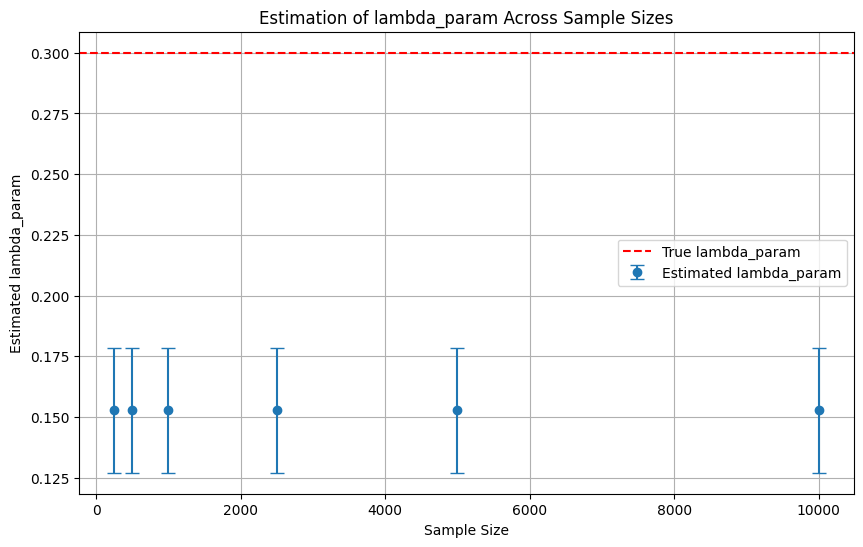

In [51]:
# Negative Log-Likelihood for lambda_param
def nll_lambda_param(lambda_param, y_vals, signal_proj, background_proj):
    """
    Negative log-likelihood for lambda_param estimation using weighted y_vals.
    Loops over each value in y_vals.
    """
    nll = 0.0
    for y, s_proj, b_proj in zip(y_vals, signal_proj, background_proj):
        signal_pdf_y = expon.pdf(y, scale=1 / lambda_param)
        total_pdf = signal_pdf_y * s_proj + b_proj
        nll -= np.log(total_pdf + 1e-10)  # Avoid log(0)
    return nll

# Function to estimate lambda_param for each sample size
def estimate_lambda_param(results, initial_guess=0.3, bounds=(0.1, 5.0)):
    estimates = {}
    for sample_size, (y_vals, signal_proj, background_proj) in results.items():
        # Define the Minuit optimization
        minuit = Minuit(
            lambda lambda_param: nll_lambda_param(lambda_param, y_vals, signal_proj, background_proj),
            lambda_param=initial_guess,
        )
        minuit.limits["lambda_param"] = bounds
        minuit.errordef = Minuit.LIKELIHOOD

        # Perform the optimization
        minuit.migrad()
        estimates[sample_size] = {
            "lambda_param": minuit.values["lambda_param"],
            "error": minuit.errors["lambda_param"]
        }

    return estimates

# Perform estimation for each sample size
lambda_estimates = estimate_lambda_param(results)

# Display results
for size, estimate in lambda_estimates.items():
    print(f"Sample Size: {size}, Estimated lambda_param: {estimate['lambda_param']:.4f}, Error: {estimate['error']:.4f}")

# Plot results
sample_sizes = list(lambda_estimates.keys())
lambda_values = [lambda_estimates[size]["lambda_param"] for size in sample_sizes]
lambda_errors = [lambda_estimates[size]["error"] for size in sample_sizes]

plt.figure(figsize=(10, 6))
plt.errorbar(sample_sizes, lambda_values, yerr=lambda_errors, fmt="o", capsize=5, label="Estimated lambda_param")
plt.axhline(0.3, color="r", linestyle="--", label="True lambda_param")
plt.xlabel("Sample Size")
plt.ylabel("Estimated lambda_param")
plt.title("Estimation of lambda_param Across Sample Sizes")
plt.legend()
plt.grid(True)
plt.show()
